In [1]:
from experimental_chromatic_fitting import *
from chromatic import Rainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample
from exoplanet import QuadLimbDark

plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.0
Running on PyMC v3.11.2
Running on ArviZ v0.12.0
Running on Exoplanet v0.5.2


# Play with a Model where Everything's Fixed
Let's start by setting up the parameters as all being fixed, and see if we can still generate a model. We'll set up a simple simulated transit first.

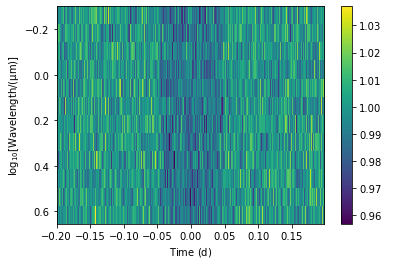

In [2]:
r = SimulatedRainbow(tlim=[-.2, .2]*u.day, R=5).inject_transit(planet_radius=0.1)
r.imshow();

We'll start a `TransitModel`. This basically just moves things around in your `chromatic_model`. In general, we could imagine splitting some of the functions up to some more general class that a `TransitModel` and a `PhaseCurveModel` and a `SystematicsModel` might all inherit from.

In [3]:
t = TransitModel()

Let's initialize an empty model, and setup the parameters for it. In this first example, the parameters are all set to defaults and they're all fixed. See below for changing them!

In [4]:
t.initialize_empty_model()
t.setup_parameters()
t.summarize_parameters()

stellar_radius =
  <🧮 Fixed | 1.0 🧮>

stellar_mass =
  <🧮 Fixed | 1.0 🧮>

radius_ratio =
  <🧮 Fixed | 1.0 🧮>

period =
  <🧮 Fixed | 1.0 🧮>

epoch =
  <🧮 Fixed | 0.0 🧮>

baseline =
  <🧮 Fixed | 1.0 🧮>

impact_parameter =
  <🧮 Fixed | 0.5 🧮>

limb_darkening =
  <🧮 Fixed | [0.2, 0.2] 🧮>



Now that the parameters are defined, we can set up the orbit. As is, there's nothing that goes into defining the orbit that should be wavelength dependent.

In [ ]:
t.setup_orbit()

In [ ]:
t.orbit.period.eval()

We can test out that the orbit is doing something reasonable by plotting the path of the planet over the time of the observation. It looks like part of a transit!

In [ ]:
with t.model:
    x, y, z = [eval_in_model(bla, point={}) for bla in t.orbit.get_planet_position(r.time)]
    plt.figure(figsize=(10,3))
    theta = np.linspace(0, 2*np.pi)
    plt.fill_between(np.cos(theta), np.sin(theta), color='gray')
    plt.scatter(x, y, c=r.time)
    plt.axis('scaled');
    plt.ylim(-1,1)

Next, we can attach the data. This is the first time the model knows anything about how many wavelengths there are, or what the times are.

In [ ]:
t.attach_data(r)

Next, we set up the light curves. This has to happen after the data is attached, because we need to know the actual times to set up the `.get_light_curve` and how many light curve models to generate (= the number of wavelengths). 

In [ ]:
t.setup_lightcurves()

Next, we set up the likelihood, meaning that we connect all the model light curves to their associated data. This is breaking things into a few different steps, but I could imagine that these are all places that we might want to change independently. For example, right now we're assuming uncorrelated Gaussian noise with no outliers, but we could quite plausibly want to use different noise distributions and/or Gaussian processes, after the basic light curve model has been set up. Of course, since we can't change any of the parameters, we can calculate a probability but we can't actually do much with it yet.

In [ ]:
t.setup_likelihood()

In [ ]:
t.model

In [ ]:
t.model.check_test_point()

I'm still *really* shaky on how `aesara` variables work, but it looks like I was able to construct an array-like thing that matches the chromatic fluxlike shape, so we can drop it in for easy visualizations of the model. The `pymc3_ext` function `eval_in_model` was a huge help here!

In [ ]:
with t.model:
    r.fluxlike[f'exoplanet-model'] = eval_in_model(t.model_chromatic_flux, point={})

In [ ]:
r.imshow_quantities(['flux', 'model', 'exoplanet-model'])

# Play with a Model where Some Parameters are Fitted

Obviously, just putting in fixed parameters everywhere is not the point of all this. So, let's make another dataset, and try to fit some parameters to it!

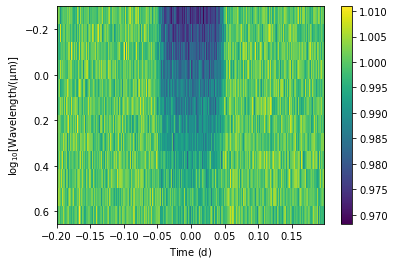

In [5]:
s = SimulatedRainbow(tlim=[-.2, .2]*u.day, R=5, signal_to_noise=300)
r = s.inject_transit(planet_radius=np.linspace(0.15, 0.05, s.nwave))
r.imshow();

The setup will look the same here.

In [6]:
t = TransitModel()

The main difference now being that we're supplying some new parameters of different kinds to the initial setup. Here, we're setting `period` to be fixed at a single value. We're setting `stellar_radius` to be fitted and shared across all wavelengths. We're setting `radius_ratio` and `limb_darkening` to be fitted and unique for each wavelength.

In [7]:
t.setup_parameters(period=3.0, 
                   stellar_radius=Fitted(Uniform, lower=0.1, upper=2.0),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05), 
                   limb_darkening=WavelikeFitted(QuadLimbDark))
t.summarize_parameters()

stellar_radius =
  <🧮 Fitted Uniform(lower=0.1, upper=2.0, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fixed | 1.0 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 3.0 🧮>

epoch =
  <🧮 Fixed | 0.0 🧮>

baseline =
  <🧮 Fixed | 1.0 🧮>

impact_parameter =
  <🧮 Fixed | 0.5 🧮>

limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(name='limb_darkening') for each wavelength 🧮>



After changing that parameter setup, everything else proceeds exactly the same as before to initialize the model. I think this is effectively what happens in your various versions of `cm.initialise...`, just split in slightly different ways. Also, typing this makes me realize that we might want to consider some English + British aliases in function names ;-)

In [9]:
t.initialize_empty_model()
t.setup_orbit()
t.attach_data(r)
t.setup_lightcurves()
t.setup_likelihood()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25266.89it/s]


In [10]:
with t.model:
    x, y, z = [eval_in_model(bla, point={}) for bla in t.orbit.get_planet_position(r.time)]
    plt.figure(figsize=(10,3))
    theta = np.linspace(0, 2*np.pi)
    plt.fill_between(np.cos(theta), np.sin(theta), color='gray')
    plt.scatter(x, y, c=r.time)
    plt.axis('scaled');
    plt.ylim(-1,1)

KeyError: 'stellar_radius_interval__'

*This is a little bit of a tanget, since your code works so beautifully to plot the priors and the posterior models, but I wanted to understand PyMC3 a little better.* I'm still trying to understand this better, but right now my understanding is that the "prior predictive" gives examples of what our datasets might look like, according to samples from the prior. That is, it's a model for the flux for each time/wavelength, with an instance of noise generated on top of it? This is slightly different than just plotted multiple version of the model, because once we start explicitly modeling noise parameters, we'll want to see what kinds of datasets can be produced, including both the central value of the model and the assumed noise around it.

In [ ]:
with t.model:
    prior_predictive_trace = sample_prior_predictive(9)

Is our actual data the kind of thing we could possibly imagine happening somewhere among the prior predictive imaginary datasets? Seems like maybe, yes?

In [ ]:
for i in range(9):
    flux_for_this_sample = np.array([prior_predictive_trace[f'wavelength_{w}_data'][i] for w in range(r.nwave)])
    r.fluxlike[f'prior-predictive-{i}'] = flux_for_this_sample
r.imshow_quantities()

OK, now, let's actually run the sampler on this.

In [ ]:
with t.model:
    trace = sample()

Once we have the samples, let's draw some posterior predictive samples of imagined datasets, and plot them.

In [ ]:
with t.model:
    posterior_predictive_trace = sample_posterior_predictive(trace, 9)

In [ ]:
for i in range(9):
    flux_for_this_sample = np.array([posterior_predictive_trace[f'wavelength_{w}_data'][i] for w in range(r.nwave)])
    r.fluxlike[f'posterior-predictive-{i}'] = flux_for_this_sample

In [ ]:
r.imshow_quantities()

Woah! That sampling is amazing; the posterior-predictive draws look qualitatively very similar to the real data! It seems to be working pretty well, at least for this (kind of easy?) toy model. I still need to connect this to all of Catriona's clever different kinds of fits and diagnostics, but for now I hope the flexible `Parameter` setup might be something useful we can start talking about? 